In [0]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from IPython import display
% matplotlib inline

! pip install torch
import torch

from sklearn.preprocessing import MinMaxScaler

### Synthetic data


In [0]:
def sample_data(sample_size, signal_freq=60):
  def sine(X, signal_freq=60.):
    return (np.sin(2 * np.pi * (X) / signal_freq) + np.sin(4 * np.pi * (X) / signal_freq)) / 2.0
  
  def noisy(Y, noise_range=(-0.05, 0.05)):
    noise = np.random.uniform(noise_range[0], noise_range[1], size=Y.shape)
    return Y + noise
  
  random_offset = random.randint(0, sample_size)
  X = np.arange(sample_size)
  Y = noisy(sine(X + random_offset, signal_freq))
  return Y

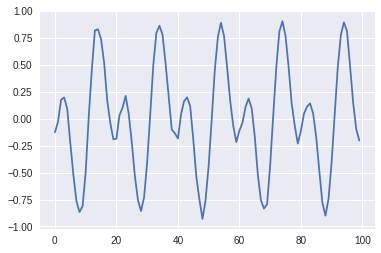

In [0]:
# data = np.array([sample_data(100, 30), sample_data(100, 15)]).T
data = sample_data(100, 20).reshape(-1, 1)
# data = np.sin(np.linspace(-2*np.pi, 2*np.pi, 100)*2).reshape(-1, 1)/2
plt.plot(data)

# HCNN (learn initial hidden state as an option)

In [0]:
class HCNNCell(torch.nn.Module):
    def __init__(self, data_dim, hidden_dim=10, init_state_trainable=True, dropout=0, sparsity=0, weight_std=0.1, weight_minmax_norm=None):
      super(HCNNCell, self).__init__()      
      
      self.init_state = None
      if init_state_trainable:
        self.init_state = torch.nn.Parameter(torch.randn(hidden_dim), requires_grad=True)
        torch.nn.init.normal_(self.init_state, std=weight_std)
      
      self.W = torch.nn.Linear(hidden_dim, hidden_dim, bias=False)
      torch.nn.init.sparse_(self.W.weight, sparsity=sparsity, std=weight_std) # https://pytorch.org/docs/0.3.1/nn.html#torch.nn.init.sparse
      
      if weight_minmax_norm is not None:
        self.W.weight.data = min_max_norm(self.W.weight.data, (-weight_minmax_norm, weight_minmax_norm))
        if self.init_state is not None:
          self.init_state.weight.data = min_max_norm(self.init_state.weight.data, (-weight_minmax_norm, weight_minmax_norm))
      
      self.dropout = torch.nn.Dropout(dropout)
      self.I = torch.cat((torch.eye(data_dim), torch.zeros(hidden_dim-data_dim, data_dim)), dim=0)
      self.data_dim = data_dim
      self.hidden_dim = hidden_dim        
    
    def forward(self, s):      
      s = torch.tanh(self.dropout(self.W(s)))
      y = torch.mm(self.I.transpose(1, 0), s.view(self.hidden_dim, 1)).view(-1)  # s[t][:data_dim]           
      return y, s
    
    
    def backward(self, s): # only for retro causal
      # if s2 = tanh(W*s1), then s1 = inv(W)*tanh_inv(s2)
      s = torch.mm(self.W.weight.data.inverse(), torch.log((1+s.data)/(1-s.data)).view(s.size()[0], 1)/2).view(-1)
      y = torch.mm(self.I.transpose(1, 0), s.view(self.hidden_dim, 1)).view(-1)  # s[t][:data_dim]           
      return y, s
    
    
    def init_state_(self, bias_std=0.1, bias_minmax_norm=None):
      bias = torch.randn(self.hidden_dim) * bias_std
      if bias_minmax_norm is not None:
        bias = min_max_norm(bias, (-bias_minmax_norm, bias_minmax_norm))
      return bias


class HCNN:
  def __init__(self, data_dim, hidden_dim=10, init_state_trainable=True, dropout=0, sparsity=0, weight_std=0.1, weight_minmax_norm=None):    
    self.hcnn = HCNNCell(
        data_dim=data_dim, 
        hidden_dim=hidden_dim, 
        init_state_trainable=init_state_trainable,
        dropout=dropout,
        sparsity=sparsity,
        weight_std=weight_std,
        weight_minmax_norm=weight_minmax_norm
    )
    
  
  def init_state(self, bias_std=0.1, bias_minmax_norm=None):
    return self.hcnn.init_state_(bias_std, bias_minmax_norm)
  
  
  @staticmethod 
  def bptt(hcnn: HCNNCell, state, data, opt, criterion):
    data = torch.tensor(data.copy()).float()

    hcnn.zero_grad()
    s = state
    loss = 0
    for t in range(len(data)):
      y, s = hcnn.forward(s)
      loss += criterion(y, data[t])
      s = s - torch.mm(hcnn.I, (y - data[t]).view(hcnn.data_dim, 1)).view(-1)

    loss.backward()
    opt.step()
    return loss.item()/len(data)
  
  
  def train(self, data, state=None, lr=0.001, epochs=10, criterion=torch.nn.MSELoss(), verbose=False, plot_loss=False, plot_pred_train=False):      
    opt=torch.optim.Adam(self.hcnn.parameters(), lr=lr)
    # criterion = LogCosh.apply  # torch.nn.MSELoss() # + self.hcnn.W.weight.abs().sum()
    
    state = self.hcnn.init_state if state is None else state.clone()
      
    losses = []
    for i in range(epochs):
      loss = self.bptt(self.hcnn, state, data, opt, criterion)
      losses.append(loss)      
      
      if verbose:
        print(f'Train epoch {i+1}/{epochs}, loss: {loss}')
        # print('W'), print(self.hcnn.W.weight.data)
        print()
        print('init_state')
        print(state)
        
      if plot_loss and (i+1)%25 == 0:
        fig, ax = plt.subplots(figsize=(3, 2), nrows=1)
        ax.plot(np.arange(1, i+2), np.array(losses), 'grey')
        ax.set_xlabel('epoch'), ax.set_ylabel('loss'), ax.set_title(f'Traning loss on epoch {i+1}: {loss}')
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.tight_layout()
        plt.close()
        
      if plot_pred_train and (i+1)%25 == 0:  
        fig, ax = plt.subplots(figsize=(15, 4), ncols=2)
        ax[0].plot(np.arange(1, i+2), np.array(losses), 'grey')
        ax[0].set_xlabel('epoch'), ax[0].set_ylabel('loss'), ax[0].set_title(f'Traning loss on epoch {i+1}: {loss}')
        
        pred = self.sample(state, int(len(data)*1.5))
        colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
        for c in range(data.shape[1]):
          ax[1].plot(pred[:, c], '--', label=f'model {c+1}', color=colors[c], alpha=1)
          ax[1].plot(data[:, c], label=f'actual {c+1}', color=colors[c], alpha=0.3)
        ax[1].set_title(f'predict (start from 0), epoch: {i+1}')
        legend_pred = ax[1].legend(frameon=True, loc='upper right')
        legend_pred.get_frame().set_color('white')
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.tight_layout()
        plt.close()
    
    return np.array(losses)
  
  
  def forward(self, state, n):
    s = state.clone()
    for t in range(n):
      y, s = self.hcnn.forward(s)
    return s   
  
  
  def backward(self, state): # only for retro causal
    s = state.clone()
    for t in range(n):
      y, s = self.hcnn.backward(s)
    return s
  
  
  def sample(self, state, n=10):
    sample = []
    s = state.clone()
    for t in range(n):
      y, s = self.hcnn(s)
      sample.append(y.detach().numpy())

    return np.array(sample)

### LogCosh activation

In [0]:
class LogCosh(torch.autograd.Function):  
    @staticmethod
    def forward(ctx, y_pred, y):
        ctx.save_for_backward(y_pred, y)
        return torch.log(torch.cosh(y_pred - y)).sum()

    @staticmethod
    def backward(ctx, grad_output):
        yy_pred, yy = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input = torch.tanh(yy_pred - yy)
        return grad_input, None

## Build hcnn

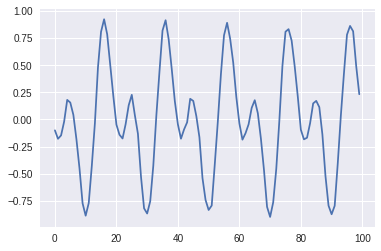

In [0]:
data = sample_data(100, 20).reshape(-1, 1)
plt.plot(data)

In [0]:
hcnn = HCNN(data_dim=data.shape[1], hidden_dim=20, weight_std=0.2, init_state_trainable=True)
# init_state = hcnn.init_state(bias_std=0.2)
# init_state
# hcnn.hcnn.init_state
# m.hcnn.W.weight

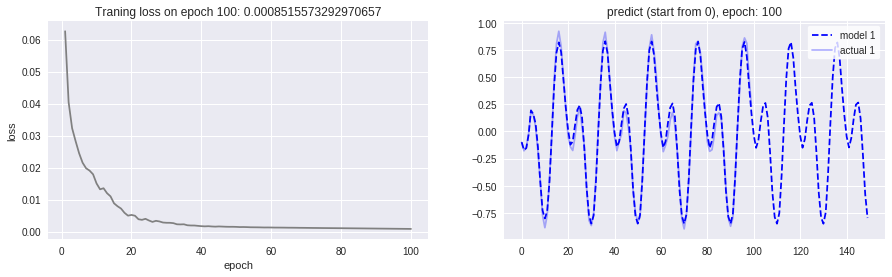

In [0]:
train_loss = hcnn.train(data, state=None, lr=0.01, epochs=100, criterion=LogCosh.apply, plot_loss=False, plot_pred_train=True, verbose=False)  # criterion=torch.nn.MSELoss() or criterion=LogCosh.apply

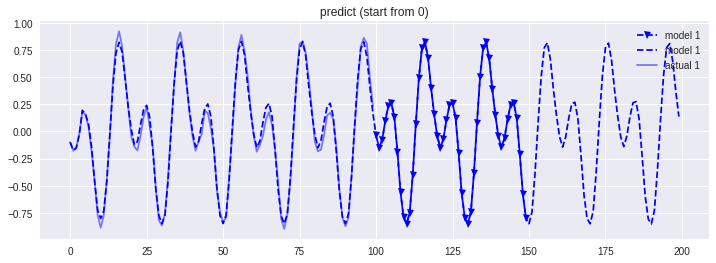

In [0]:
fig, ax = plt.subplots(figsize=(12, 4))

pred = hcnn.sample(hcnn.hcnn.init_state, int(len(data)*2.0))
pred_test = hcnn.sample(hcnn.forward(hcnn.hcnn.init_state, len(data)), int(len(data)*0.5))
colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
for c in range(data.shape[1]):
  ax.plot(np.arange(pred_test.shape[0]) + data.shape[0], pred_test[:, c], 'v--', label=f'model {c+1}', color=colors[c], alpha=1)
  ax.plot(pred[:, c], '--', label=f'model {c+1}', color=colors[c], alpha=1)
  ax.plot(data[:, c], label=f'actual {c+1}', color=colors[c], alpha=0.5)
ax.set_title(f'predict (start from 0)')
ax.legend()

# CRC-HCNN

CRC-HCNN is able to make forecasts only on **finite forecast horizon** rather than HCCN. That's because retro causal net has to be initialized with initial state that is N steps ahead of train data, in order to make forecast (backward) on N time stamps after training data.

In [0]:
class CRCHCNN:
  def __init__(self, data_dim, hidden_dim=10, init_state_trainable=True, dropout=0, sparsity=0, weight_std=0.1, weight_minmax_norm=None, forecast_horizon=10):    
    self.hcnn_c = HCNN(
        data_dim=data_dim, 
        hidden_dim=hidden_dim, 
        init_state_trainable=init_state_trainable,
        dropout=dropout,
        sparsity=sparsity,
        weight_std=weight_std,
        weight_minmax_norm=weight_minmax_norm
    )
    
    self.hcnn_rc = HCNN(
        data_dim=data_dim, 
        hidden_dim=hidden_dim, 
        init_state_trainable=init_state_trainable,
        dropout=dropout,
        sparsity=sparsity,
        weight_std=weight_std,
        weight_minmax_norm=weight_minmax_norm
    )
    
    self.forecast_horizon = forecast_horizon
        
  
  def train(self, data, state_c=None, state_rc=None, lr=0.001, epochs=10, criterion=torch.nn.MSELoss(), verbose=False, plot_loss=False, plot_pred_train=False):      
    opt_c = torch.optim.Adam(self.hcnn_c.hcnn.parameters(), lr=lr)
    opt_rc = torch.optim.Adam(self.hcnn_rc.hcnn.parameters(), lr=lr)
    # criterion = LogCosh.apply  # torch.nn.MSELoss() # + self.hcnn.W.weight.abs().sum()
    
    state_c = self.hcnn_c.hcnn.init_state if state_c is None else state_c.clone()
    state_rc = self.hcnn_rc.hcnn.init_state if state_rc is None else state_rc.clone()
      
    losses, losses_c, losses_rc = [], [], []
    for i in range(epochs):
      y_c_sample = self.hcnn_c.sample(state_c, len(data)) # from start to end
      # y_rc_sample = self.hcnn_rc.sample(state_rc, len(data)) # from end to start
      
      # init_state of rc hcnn is shifted on forecast_horizon so we could make prediction into future on forecast horizon
      y_rc_sample = self.hcnn_rc.sample(state_rc, len(data)+self.forecast_horizon)[self.forecast_horizon:] # from end to start
      
      loss_c = self.hcnn_c.bptt(self.hcnn_c.hcnn, state_c, data - y_rc_sample[::-1], opt_c, criterion)
      loss_rc = self.hcnn_rc.bptt(self.hcnn_rc.hcnn, state_rc, data[::-1] - y_c_sample[::-1], opt_rc, criterion)
      losses_c.append(loss_c)
      losses_rc.append(loss_rc)
      
      # y_crc = self.hcnn_c.sample(state_c, len(data)) + self.hcnn_rc.sample(state_rc, len(data))[::-1]
      y_crc = self.hcnn_c.sample(state_c, len(data)) + self.hcnn_rc.sample(state_rc, len(data)+self.forecast_horizon)[self.forecast_horizon:][::-1]
      loss_crc = criterion(torch.tensor(y_crc).float(), torch.tensor(data).float()) / len(data)
      losses.append(loss_crc)      
      
      if verbose:
        print(f'Train epoch {i+1}/{epochs}, loss: {loss}')
        # print('W'), print(self.hcnn.W.weight.data)
        # print()
        print('init_state rc')
        print(state_rc)
        print('y_crc')
        print(y_crc)
        
      if plot_loss and (i+1)%25 == 0:
        fig, ax = plt.subplots()
        ax.plot(np.arange(1, i+2), np.array(losses), 'grey', alpha=0.5, label=f'crc loss: {loss_crc}')
        ax.plot(np.arange(1, i+2), np.array(losses_c), label=f'causal loss: {loss_c}')
        ax.plot(np.arange(1, i+2), np.array(losses_rc), label=f'retro-causal loss: {loss_rc}')
        ax.set_xlabel('epoch'), ax.set_ylabel('loss'), ax.set_title(f'Traning loss on epoch {i+1}')
        legend_loss = ax.legend(frameon=True, loc='upper right')
        legend_loss.get_frame().set_color('white')
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.close()
        
      if plot_pred_train and (i+1)%25 == 0:  
        fig, ax = plt.subplots(figsize=(15, 4), ncols=2)
        ax[0].plot(np.arange(1, i+2), np.array(losses), 'grey', alpha=0.5, label=f'crc loss: {loss_crc}')
        ax[0].plot(np.arange(1, i+2), np.array(losses_c), label=f'causal loss: {loss_c}')
        ax[0].plot(np.arange(1, i+2), np.array(losses_rc), label=f'retro-causal loss: {loss_rc}')
        ax[0].set_xlabel('epoch'), ax[0].set_ylabel('loss'), ax[0].set_title(f'Traning loss on epoch {i+1}')
        legend_loss = ax[0].legend(frameon=True, loc='upper right')
        legend_loss.get_frame().set_color('white')
        
        pred = y_crc
        colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
        for c in range(data.shape[1]):
          ax[1].plot(pred[:, c], '--', label=f'model {c+1}', color=colors[c], alpha=1)
          ax[1].plot(data[:, c], label=f'actual {c+1}', color=colors[c], alpha=0.3)
        ax[1].set_title(f'predict (start from 0), epoch: {i+1}')
        legend_pred = ax[1].legend(frameon=True, loc='upper right')
        legend_pred.get_frame().set_color('white')
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.tight_layout()
        plt.close()
    
    return np.array(losses)
  
  
  def sample(self, state_c, state_rc, n=None):
    # sample_c = self.hcnn_c.sample(state_c, n)
    # sample_rc = self.hcnn_rc.sample(state_rc, n)
    
    sample_c = self.hcnn_c.sample(state_c, self.forecast_horizon)
    sample_rc = self.hcnn_rc.sample(state_rc, self.forecast_horizon)
    sample = sample_c + sample_rc[::-1]

    return np.array(sample)

## Build CRC-HCNN

### Airline data

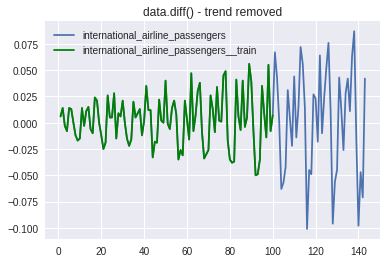

In [0]:
df = pd.read_csv('international-airline-passengers.csv', index_col=0)
df.index = range(0, len(df))
df /= 1000
# df.plot()
data = df.diff()  # remove trend
data = data.iloc[1:]
train_test_split_index = 100
data_train = data[:train_test_split_index]

fig, ax = plt.subplots()
data.plot(ax=ax, title='data.diff() - trend removed')
data_train.rename(columns={c:'{}__train'.format(c) for c in data_train.columns}).plot(ax=ax, color='g')

In [0]:
crchcnn = CRCHCNN(data_dim=data.shape[1], hidden_dim=50, sparsity=0.3, weight_std=0.1, forecast_horizon=data.shape[0])

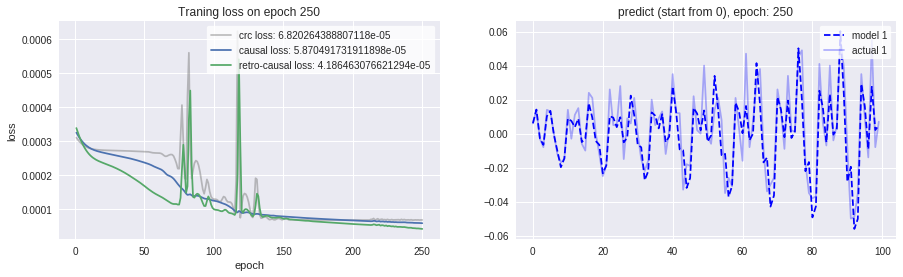

In [0]:
train_loss = crchcnn.train(data_train.values, lr=0.0005, epochs=250, criterion=LogCosh.apply, plot_pred_train=True)

#### Forecast with CRC-HCNN

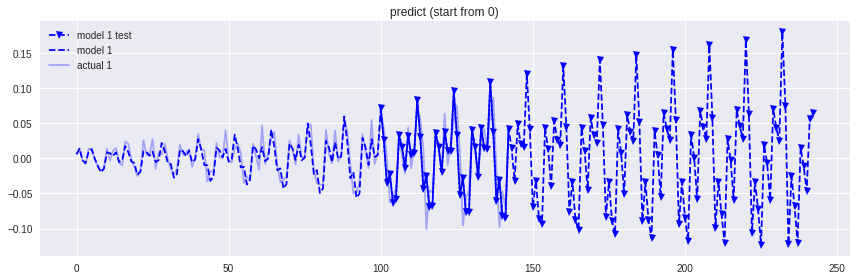

In [0]:
fig, ax = plt.subplots(figsize=(12, 4))

pred = crchcnn.sample(
    state_c=crchcnn.hcnn_c.hcnn.init_state, 
    state_rc=crchcnn.hcnn_rc.forward(crchcnn.hcnn_rc.hcnn.init_state, crchcnn.forecast_horizon),
)
pred_test = crchcnn.sample(
    state_c=crchcnn.hcnn_c.forward(crchcnn.hcnn_c.hcnn.init_state, len(data_train)), 
    state_rc=crchcnn.hcnn_rc.hcnn.init_state,
)

colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
for c in range(data.shape[1]):
  ax.plot(np.arange(pred_test.shape[0]) + data_train.shape[0], pred_test[:, c], 'v--', label=f'model {c+1} test', color=colors[c], alpha=1)
  ax.plot(pred[:, c], '--', label=f'model {c+1}', color=colors[c], alpha=1)
  ax.plot(data.values[:, c], label=f'actual {c+1}', color=colors[c], alpha=0.3)
ax.set_title(f'predict (start from 0)')
ax.legend()
plt.tight_layout()

##### Forecast with causal hcnn (of trained CRC-HCNN)

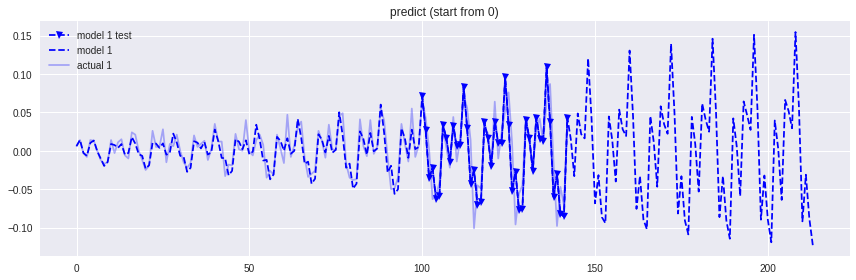

In [0]:
fig, ax = plt.subplots(figsize=(12, 4))

pred = crchcnn.hcnn_c.sample(crchcnn.hcnn_c.hcnn.init_state, int(len(data)*1.5))
pred_test = crchcnn.hcnn_c.sample(crchcnn.hcnn_c.forward(crchcnn.hcnn_c.hcnn.init_state, len(data_train)), int(len(data) - len(data_train)))

colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
for c in range(data.shape[1]):
  ax.plot(np.arange(pred_test.shape[0]) + data_train.shape[0], pred_test[:, c], 'v--', label=f'model {c+1} test', color=colors[c], alpha=1)
  ax.plot(pred[:, c], '--', label=f'model {c+1}', color=colors[c], alpha=1)
  ax.plot(data.values[:, c], label=f'actual {c+1}', color=colors[c], alpha=0.3)
ax.set_title(f'predict (start from 0)')
ax.legend()
plt.tight_layout()

### Synthetic data

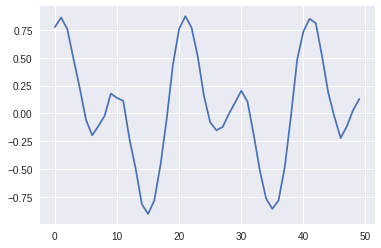

In [0]:
data = sample_data(50, 20).reshape(-1, 1)
plt.plot(data)

In [0]:
crchcnn = CRCHCNN(data_dim=data.shape[1], hidden_dim=20, weight_std=0.2, forecast_horizon=data.shape[0])

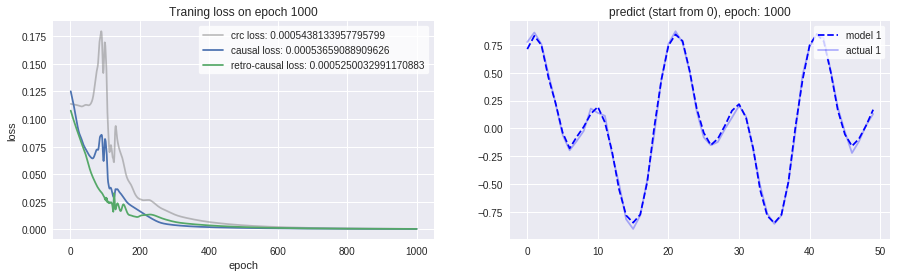

In [0]:
train_loss = crchcnn.train(data, lr=0.0005, epochs=1000, criterion=LogCosh.apply, plot_pred_train=True, verbose=False)

#### Forecast with CRC-HCNN

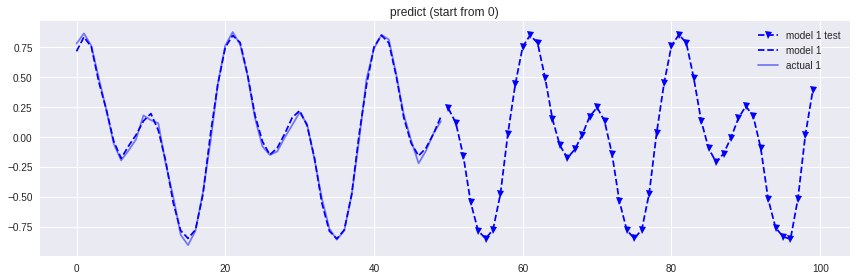

In [0]:
fig, ax = plt.subplots(figsize=(12, 4))

pred = crchcnn.sample(
    state_c=crchcnn.hcnn_c.hcnn.init_state, 
    state_rc=crchcnn.hcnn_rc.forward(crchcnn.hcnn_rc.hcnn.init_state, crchcnn.forecast_horizon),
)
pred_test = crchcnn.sample(
    state_c=crchcnn.hcnn_c.forward(crchcnn.hcnn_c.hcnn.init_state, len(data)), 
    state_rc=crchcnn.hcnn_rc.hcnn.init_state,
)

colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
for c in range(data.shape[1]):
  ax.plot(np.arange(pred_test.shape[0]) + data.shape[0], pred_test[:, c], 'v--', label=f'model {c+1} test', color=colors[c], alpha=1)
  ax.plot(pred[:, c], '--', label=f'model {c+1}', color=colors[c], alpha=1)
  ax.plot(data[:, c], label=f'actual {c+1}', color=colors[c], alpha=0.5)
ax.set_title(f'predict (start from 0)')
ax.legend()
plt.tight_layout()

##### Forecast with causal hcnn (of trained CRC-HCNN)

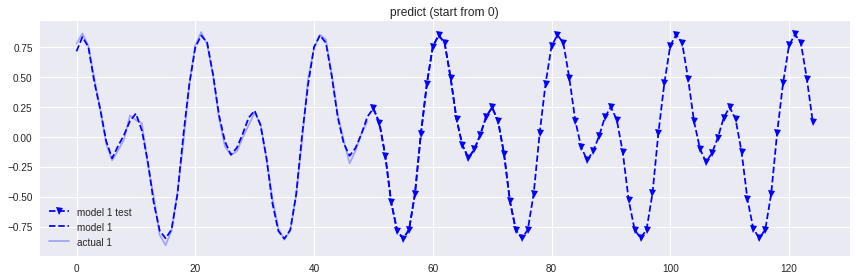

In [0]:
fig, ax = plt.subplots(figsize=(12, 4))

pred = crchcnn.hcnn_c.sample(crchcnn.hcnn_c.hcnn.init_state, int(len(data)*1.5))
pred_test = crchcnn.hcnn_c.sample(crchcnn.hcnn_c.forward(crchcnn.hcnn_c.hcnn.init_state, len(data)), int(len(data)*1.5))

colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
for c in range(data.shape[1]):
  ax.plot(np.arange(pred_test.shape[0]) + data.shape[0], pred_test[:, c], 'v--', label=f'model {c+1} test', color=colors[c], alpha=1)
  ax.plot(pred[:, c], '--', label=f'model {c+1}', color=colors[c], alpha=1)
  ax.plot(data[:, c], label=f'actual {c+1}', color=colors[c], alpha=0.3)
ax.set_title(f'predict (start from 0)')
ax.legend()
plt.tight_layout()

# MACRO DATA

In [0]:
macro = pd.read_csv('macro.csv', index_col=0)
macro_train = macro.iloc[:-15]
print(f'Train: {len(macro_train)} (obs.)')

Train: 45 (obs.)


In [0]:
crchcnn = CRCHCNN(data_dim=macro.shape[1], hidden_dim=500, sparsity=0.99, weight_std=0.3, forecast_horizon=macro.shape[0])

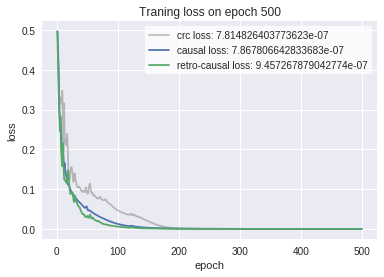

In [0]:
train_loss = crchcnn.train(macro_train.values, lr=0.0005, epochs=500, criterion=LogCosh.apply, plot_loss=True, plot_pred_train=False, verbose=False)

#### Forecast

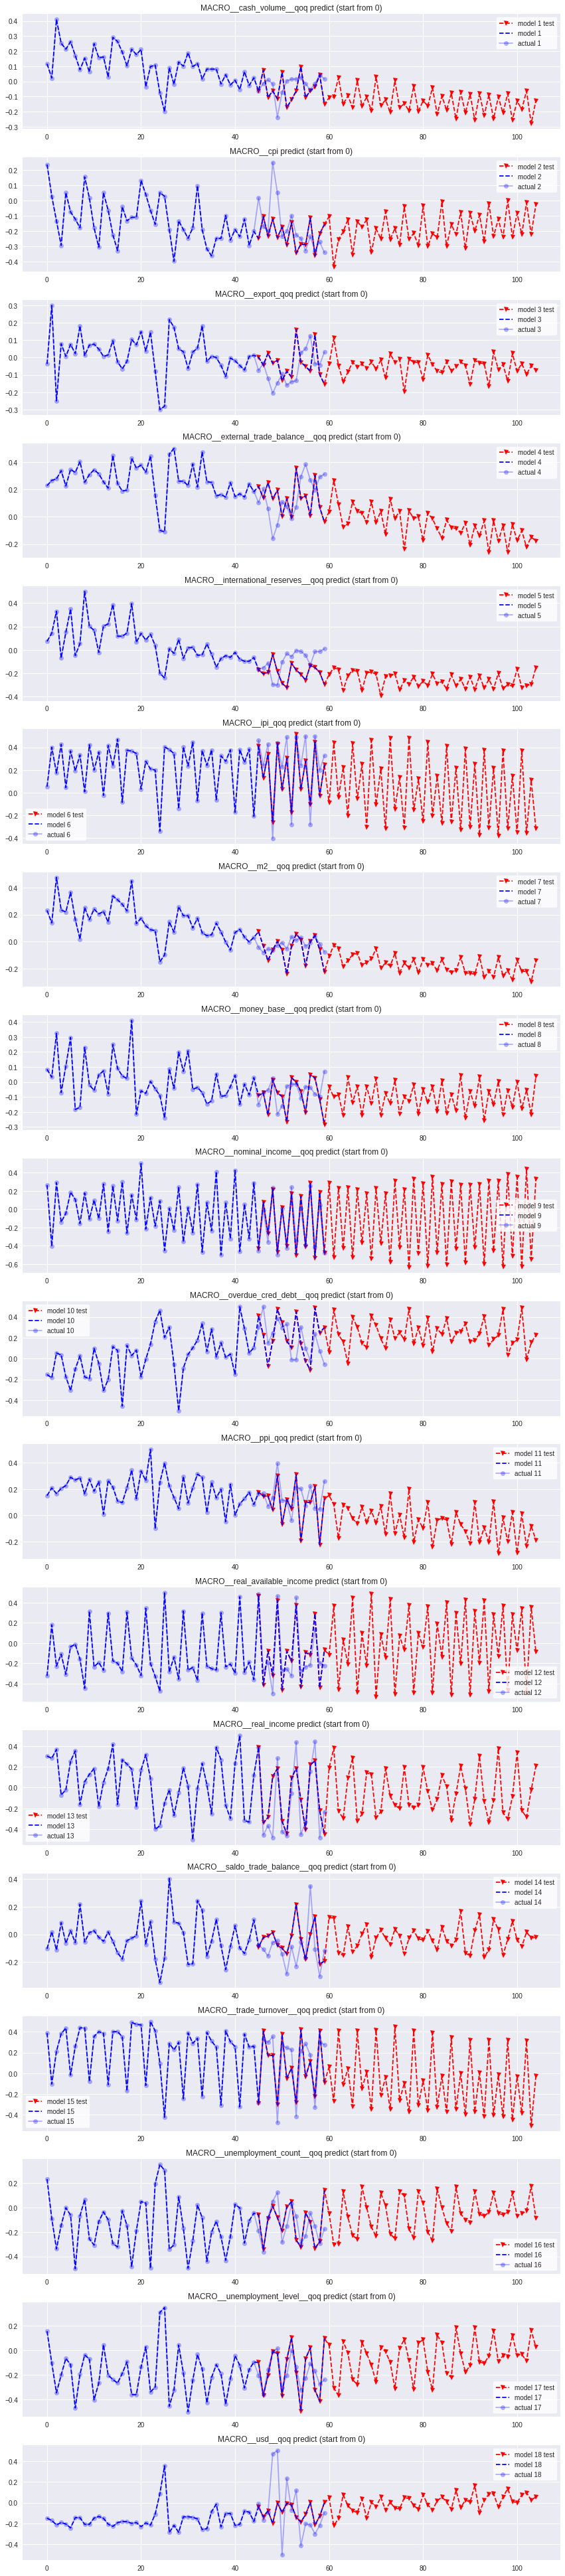

In [0]:
fig, ax = plt.subplots(figsize=(12, 3*macro.shape[1]), nrows=macro.shape[1])

pred = crchcnn.sample(
    state_c=crchcnn.hcnn_c.hcnn.init_state, 
    state_rc=crchcnn.hcnn_rc.forward(crchcnn.hcnn_rc.hcnn.init_state, crchcnn.forecast_horizon),
)
pred_test = crchcnn.sample(
    state_c=crchcnn.hcnn_c.forward(crchcnn.hcnn_c.hcnn.init_state, len(macro_train)), 
    state_rc=crchcnn.hcnn_rc.hcnn.init_state,
)

for c in range(macro.shape[1]):
  ax[c].plot(np.arange(pred_test.shape[0]) + macro_train.shape[0], pred_test[:, c], 'v--', label=f'model {c+1} test', color='red', alpha=1)
  ax[c].plot(pred[:, c], '--', label=f'model {c+1}', color='blue', alpha=1)
  ax[c].plot(macro.values[:, c], 'o-', label=f'actual {c+1}', color='blue', alpha=0.3)
  ax[c].set_title(f'{macro.columns[c]} predict (start from 0)')
  legend_pred = ax[c].legend(frameon=True)
  legend_pred.get_frame().set_color('white')
plt.tight_layout()